# Introduction and Background

## Research Question
Are there specific months for movie release dates that generate more revenue in the box office? Is there a correlation between movie budgets and their success in the box office?

## Background
This is a question of interest because the film industry may be able to find some different strategies to maximize their revenue, such as the best time to release their new movies or determine how much their budget will correlate to potential revenue. With so many movies always coming out, we wondered if there was a correlation between box office success and release dates in conjunction with how big a movie’s budgets is. In some of our background research we found that the number of user votes on IMDB for a movie corresponds with how well-known the film is, and that critics’ reviews don’t have that much of an influence on the success of a movie. 

We always hear about big budget movies because they’re the ones that usually have the ability to advertise the film to the point where everyone sees it. But sometimes movies with relatively small budgets rise to the top of the the box offices. Content has something to do with it, but we want to see how much of an impact the time at which you release a movie has on the success of the film. There have been some blog posts about which genre generally gets released for each month, and there was some indication that the winter months would be when the best movies (Oscar nominated ones) come out. 

Our question is important because it presents a visualization for the correlation between box office success and release dates in conjuction with movie budgets. We want to know if there is a strong correlation and if there is a pattern to movie release dates. It is unclear if there are popular months for movie releases or box office success. 

References (include links):
- Movie Budget and Financial Performance Records (https://www.the-numbers.com/movie/budgets/) 
-- Tables that show top 20 movies that compare the movie's budget and revenue (greatest lost and earnings).
- Analysis of factor affecting the success of the movie (http://rstudio-pubs-static.s3.amazonaws.com/233939_bbeb292c0c20440f97d31b616662c06f.html)
-- Analysis between different website user voting data and the success of the movie in the box office in conjuction with the movie's budget. 
- Movie Release Calendar Strategy (https://riotstudios.com/blog/movie-release-calendar-strategy/) 
-- Months associated with genre/movie style released.

## Hypothesis
We predict that if a movie is released during July or August, then it will generate more revenue in the box office. We also predict that if a movie has a big budget, then it will generate more revenue in the box office. 

# Data Description

This is a list of ~5000 movies from The Movie Database website. This dataset contains rows of movies with columns that dictate details of the movie. For example, the list contains keyword, revenue, budget, production company, imdb id, language, runtime, release date, and ratings concerning each movie.

- Dataset Name: TMDb 5000 Movie Dataset
- Link to the dataset: https://www.kaggle.com/tmdb/tmdb-movie-metadata/data
- Number of observations: 4803

This is a list of ~45000 movies from The Movie Database. This list contains budget, genre, original language, popularity, revenue, imdb id, adulterated, production company, homepage, collection, poster, overview, video, tagline, title, vote count, id, runtime, release date, and vote average (0-10) for each movie. 

- Dataset Name: Movies Metadata
- Link to the dataset: https://www.kaggle.com/rounakbanik/the-movies-dataset/data
- Number of observations: 45466

We may be merging the datasets and compare if there are any duplicates, if so, we will compare the ‘revenue’, ‘budget’, and ‘release date’ and remove the duplicates. If there are any conflicting comparisons, we will manually change the data to the correct values. 

## Data Cleaning/Pre-processing


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

!pip install easymoney
from easymoney.money import EasyPeasy

/Users/sarah/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


    100% |████████████████████████████████| 9.7MB 122kB/s eta 0:00:01
  Running setup.py bdist_wheel for easymoney ... done
  Stored in directory: /Users/sarah/Library/Caches/pip/wheels/c0/aa/d9/4cc4ce15d7722772b7c21de8bcc2fa1a2345fb4d5cd89a657b
  Running setup.py bdist_wheel for pycountry ... done
  Stored in directory: /Users/sarah/Library/Caches/pip/wheels/8e/41/09/9a91004166f9ed503f568eca67141648be1e263021a3d1a5d7
  Running setup.py bdist_wheel for wbdata ... done
  Stored in directory: /Users/sarah/Library/Caches/pip/wheels/6c/cc/78/79154effbbf225d0f06d9b6a270093fe100dd2dc7bbf74007a
Successfully built easymoney pycountry wbdata
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# Import datafile tmdb_5000_movies.csv to df1

df1 = pd.read_csv('tmdb_5000_movies.csv')

In [4]:
# Import datafile movies_metadata.csv to df2
df2 = pd.read_csv('movies_metadata.csv', low_memory=False)

In [5]:
# Drop unrelated columns
df1.drop(['homepage', 'keywords', 'overview', 'runtime', 'tagline'], axis=1, inplace=True)
df2.drop(['adult', 'belongs_to_collection', 'homepage', 'imdb_id', 'overview', 'poster_path', 'runtime', 'video', 'tagline'], axis=1, inplace=True)

In [6]:
# Change str to int and drop all unnemerical elements
pd.to_numeric(df1['revenue'], errors='coerce')
pd.to_numeric(df1['budget'], errors='coerce')
pd.to_numeric(df2['revenue'], errors='coerce')
pd.to_numeric(df2['budget'], errors='coerce') 

df1.dropna(subset = ["revenue","budget"],inplace=True)
df2.dropna(subset = ["revenue","budget"],inplace=True)
df2.budget = df2.budget.astype(np.int64)

In [7]:
# Drop unrepresentable/abnormal value for revenue and budget 
df1 = df1[df1.revenue >= 1000]
df2 = df2[df2.revenue >= 1000]
df1 = df1[df1.budget >= 1000]
df2 = df2[df2.budget >= 1000]

In [8]:
# Concat two dataset into one called df
df = pd.concat([df1, df2], ignore_index=True)

In [9]:
# Drop repeated infomation.
df.drop_duplicates('id', inplace=True)

In [10]:
# Split the release date to year month and date 
df['year'] = pd.DatetimeIndex(df['release_date']).year
df['month'] = pd.DatetimeIndex(df['release_date']).month
df['date'] = pd.DatetimeIndex(df['release_date']).day

In [11]:
# Remove the movies that may be too old
df = df[df.year >= 1990]

In [12]:
# Adjust inflation rate 
ep = EasyPeasy()

In [13]:
# Adjust the inflation of budget, make a new column called adjusted_budget
adjusted_budget = []
for index, row in df.iterrows():
    adjusted_budget.append(ep.normalize(amount=row['budget'], region="US", from_year=row['year'], to_year='latest',base_currency="USD", pretty_print=False))
df['adjusted_budget'] = adjusted_budget

/Users/sarah/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 2017 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2016.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


In [14]:
# Adjust the inflation of revenue, make a new column called adjusted_revenue
adjusted_revenue = []
for index, row in df.iterrows():
    adjusted_revenue.append(ep.normalize(amount=row['revenue'], region="US", from_year=row['year'], to_year='latest',base_currency="USD", pretty_print=False))
df['adjusted_revenue'] = adjusted_revenue

/Users/sarah/anaconda3/lib/python3.6/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 2017 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2016.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


In [15]:
# Add column return_rate and profit
df['return_rate'] = df['adjusted_revenue']/df['adjusted_budget']
df['profit'] = df['adjusted_revenue']- df['adjusted_budget']

In [16]:
# In this step, we are going to deal with outlier values by removing all rows in which the data for the return rate column exceeds +/- 3 standard deviations above or below the mean.
std3 = 3 * df['return_rate'].std()
std_max = df['return_rate'].mean() + std3
std_min = df['return_rate'].mean() - std3

In [17]:
# Now use these values to remove any rows with return_rate data above or below these thresholds
df = df[df['return_rate'] > std_min]
df = df[df['return_rate'] < std_max]

In [18]:
# Use the method below to extract the main genres. 
def extract_main_genre(genres):
    s = genres
    # Find the first : after id
    start = s.find(':') + 1
    s = s[start:]
    start = s.find(':') + 3
    end = s.find('}') - 1
    return s[start:end]
df['main_genre'] = df["genres"].apply(extract_main_genre)

In [19]:
# Use the method below to extract the main production company
def extract_main_production(companies):
    return companies[companies.find(':') + 3: companies.find(",") - 1]
df['main_production_company'] = df['production_companies'].apply(extract_main_production)

In [20]:
# Check if any rows have empty genre
empty_genre = sum(df.main_genre == '')
empty_production = sum(df.main_production_company == '')

print ("There are ", empty_genre, " rows that do not contain a genre.")
print ("There are ", empty_production, " rows that do not contain a production company.")

There are  9  rows that do not contain a genre.
There are  184  rows that do not contain a production company.


In [21]:
# Function to check empty column values
def empty_string(string):
    output = None
    if (string == ''):
        output = np.nan
    else:
        output = string
    return output

In [22]:
# Applying the transformation and dropping invalid rows
df["main_production_company"] = df["main_production_company"].apply(empty_string)
df.dropna(subset=['main_production_company'], inplace=True)

In [23]:
# Applying the transformation and dropping invalid rows
df["main_genre"] = df["main_genre"].apply(empty_string)
df.dropna(subset=['main_genre'], inplace=True)

In [24]:
# Drop used, cleaned columns
df.drop(['original_title', 'production_countries', 'spoken_languages', 'status', 'budget', 'genres', 'popularity', 'original_language', 'id', 'production_companies', 'release_date', 'year', 'date', 'revenue', 'budget', 'vote_count'], axis=1, inplace=True)

### The cell below drops all rows that are from production companies that produced less than 50 films -- can comment out to see if there is a difference in data

In [25]:
# Check the different production companies, including how many films were produced from each company
counts = df.main_production_company.value_counts()

# Any production company that produces more than 50 films will be kept in our data
print(counts[counts > 50])
df = df[df['main_production_company'].isin(counts[counts > 50].index)]

Universal Pictures                        439
Paramount Pictures                        411
Columbia Pictures                         338
Twentieth Century Fox Film Corporation    285
New Line Cinema                           283
Walt Disney Pictures                      218
Miramax Films                             147
Village Roadshow Pictures                 136
DreamWorks SKG                            115
Fox Searchlight Pictures                   98
Warner Bros.                               92
Summit Entertainment                       89
Columbia Pictures Corporation              88
TriStar Pictures                           81
Lionsgate                                  63
Regency Enterprises                        60
Imagine Entertainment                      59
The Weinstein Company                      58
Touchstone Pictures                        58
Lions Gate Films                           55
Name: main_production_company, dtype: int64


In [26]:
# Check what the df looks like as of now
df.head()
df

,title,vote_average,month,adjusted_budget,adjusted_revenue,return_rate,profit,main_genre,main_production_company
1,Pirates of the Caribbean: At World's End,6.9,5,3.472620e+08,1.112396e+09,3.203333,7.651340e+08,Adventure,Walt Disney Pictures
2,Spectre,6.3,10,2.480909e+08,8.917851e+08,3.594590,6.436942e+08,Action,Columbia Pictures
4,John Carter,6.1,3,2.717923e+08,2.970263e+08,1.092843,2.523393e+07,Action,Walt Disney Pictures
5,Spider-Man 3,5.9,5,2.986454e+08,1.031220e+09,3.452991,7.325743e+08,Fantasy,Columbia Pictures
6,Tangled,7.4,11,2.861742e+08,6.513710e+08,2.276134,3.651968e+08,Animation,Walt Disney Pictures
8,Harry Potter and the Half-Blood Prince,7.4,7,2.796804e+08,1.044840e+09,3.735837,7.651599e+08,Adventure,Warner Bros.
12,Pirates of the Caribbean: Dead Man's Chest,7.0,6,2.381122e+08,1.268733e+09,5.328299,1.030621e+09,Adventure,Walt Disney Pictures
13,The Lone Ranger,5.9,7,2.627172e+08,9.199213e+07,0.350157,-1.707250e+08,Action,Walt Disney Pictures
16,The Avengers,7.4,4,2.299781e+08,1.588478e+09,6.907081,1.358499e+09,Science Fiction,Paramount Pictures
17,Pirates of the Caribbean: On Stranger Tides,6.4,5,4.054551e+08,1.115763e+09,2.751878,7.103080e+08,Adventure,Walt Disney Pictures


# Data Visualization
First, we need to do some exploratory data visualization, to get a feel for the data. 


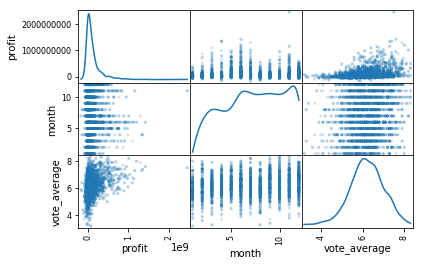

In [27]:
# Plot the data, using scatter_matrix, from Pandas. Assign it to a variable called 'fig'.
fig = pd.plotting.scatter_matrix(df[['profit','month','vote_average']], alpha=0.2, diagonal='kde')

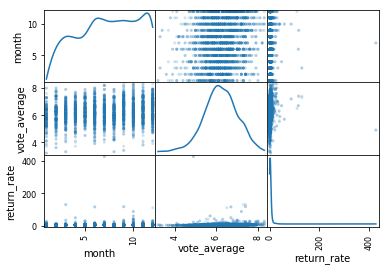

In [28]:
fig = pd.plotting.scatter_matrix(df[['month','vote_average','return_rate']], alpha=0.2, diagonal='kde')

We can see that most of the movies' return rates are close to each other and under 100, but there are some movies with extremely high return rate.

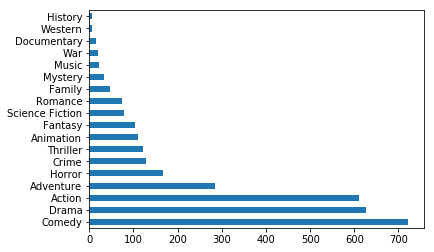

In [29]:
# Plot a bar chart showing the number of movies in each genre. 
df.main_genre.value_counts().plot.barh()
f1 = plt.gcf()

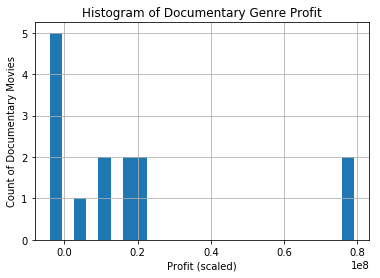

In [30]:
df[df["main_genre"] == 'Documentary'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Documentary Movies')
plt.title('Histogram of Documentary Genre Profit')
f_Documentary = plt.gcf()

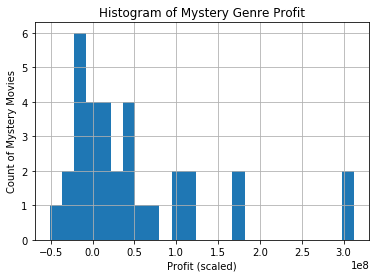

In [31]:
df[df["main_genre"] == 'Mystery'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Mystery Movies')
plt.title('Histogram of Mystery Genre Profit')
f_Mystery = plt.gcf()

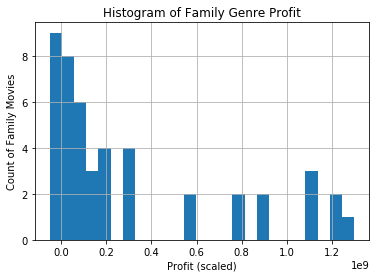

In [32]:
df[df["main_genre"] == 'Family'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Family Movies')
plt.title('Histogram of Family Genre Profit')
f_Family = plt.gcf()

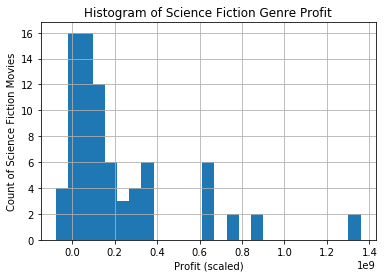

In [33]:
df[df["main_genre"] == 'Science Fiction'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Science Fiction Movies')
plt.title('Histogram of Science Fiction Genre Profit')
f_Science_Fiction = plt.gcf()

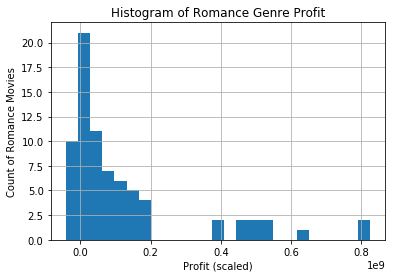

In [34]:
df[df["main_genre"] == 'Romance'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Romance Movies')
plt.title('Histogram of Romance Genre Profit')
f_Romance = plt.gcf()

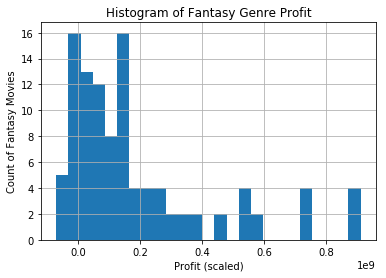

In [35]:
df[df["main_genre"] == 'Fantasy'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Fantasy Movies')
plt.title('Histogram of Fantasy Genre Profit')
f_Fantasy = plt.gcf()

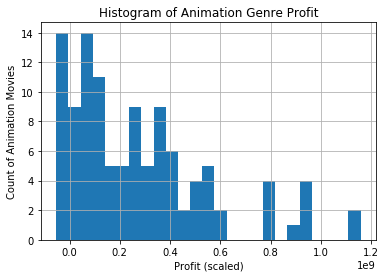

In [36]:
df[df["main_genre"] == 'Animation'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Animation Movies')
plt.title('Histogram of Animation Genre Profit')
f_Animation = plt.gcf()

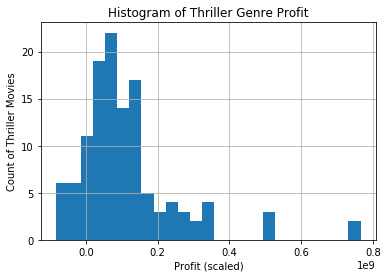

In [37]:
df[df["main_genre"] == 'Thriller'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Thriller Movies')
plt.title('Histogram of Thriller Genre Profit')
f_Animation = plt.gcf()

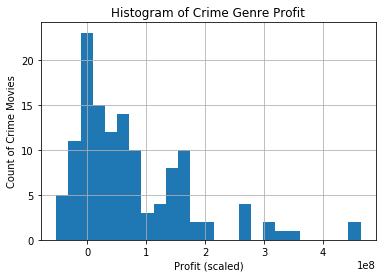

In [38]:
df[df["main_genre"] == 'Crime'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Crime Movies')
plt.title('Histogram of Crime Genre Profit')
f_Crime = plt.gcf()

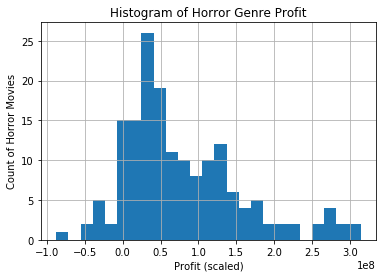

In [39]:
df[df["main_genre"] == 'Horror'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Horror Movies')
plt.title('Histogram of Horror Genre Profit')
f_Horror = plt.gcf()

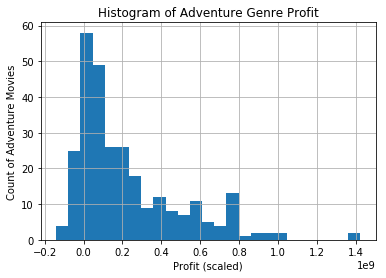

In [40]:
df[df["main_genre"] == 'Adventure'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Adventure Movies')
plt.title('Histogram of Adventure Genre Profit')
f_Adventure = plt.gcf()

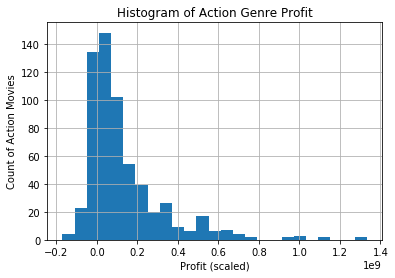

In [41]:
df[df["main_genre"] == 'Action'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Action Movies')
plt.title('Histogram of Action Genre Profit')
f_Action = plt.gcf()

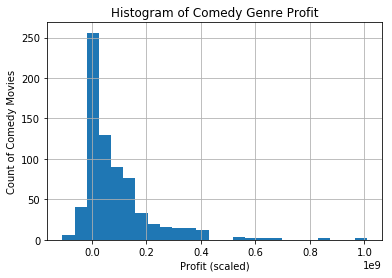

In [42]:
df[df["main_genre"] == 'Comedy'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Comedy Movies')
plt.title('Histogram of Comedy Genre Profit')
f_Comedy = plt.gcf()

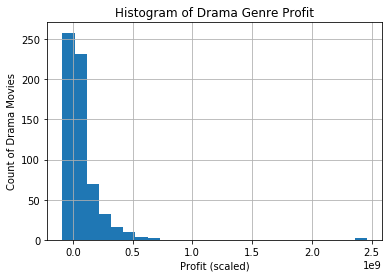

In [43]:
df[df["main_genre"] == 'Drama'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Drama Movies')
plt.title('Histogram of Drama Genre Profit')
f_Drama = plt.gcf()

Continuing to see profit trends depending on different variables, we will see profit trends concerning months.

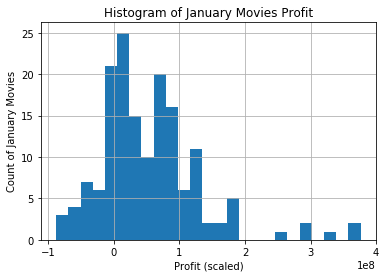

In [44]:
df[df["month"] == 1].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of January Movies')
plt.title('Histogram of January Movies Profit')
f_January = plt.gcf()

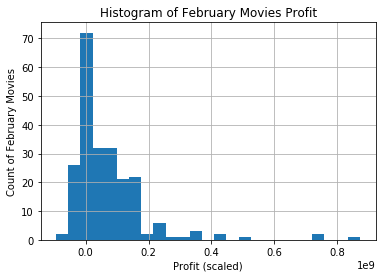

In [45]:
df[df["month"] == 2].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of February Movies')
plt.title('Histogram of February Movies Profit')
f_February = plt.gcf()

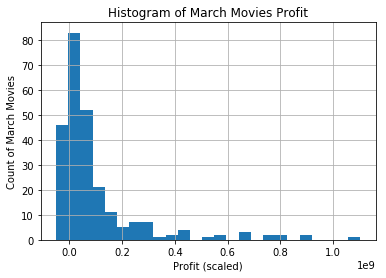

In [46]:
df[df["month"] == 3].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of March Movies')
plt.title('Histogram of March Movies Profit')
f_March = plt.gcf()

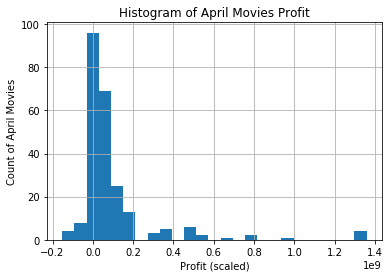

In [47]:
df[df["month"] == 4].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of April Movies')
plt.title('Histogram of April Movies Profit')
f_April = plt.gcf()

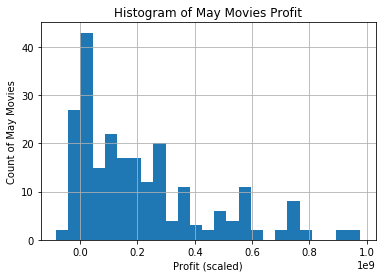

In [48]:
df[df["month"] == 5].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of May Movies')
plt.title('Histogram of May Movies Profit')
f_May = plt.gcf()

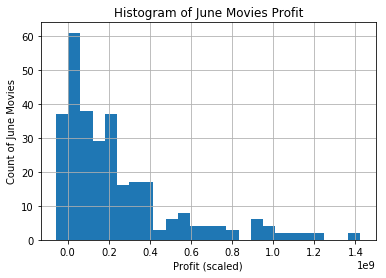

In [49]:
df[df["month"] == 6].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of June Movies')
plt.title('Histogram of June Movies Profit')
f_June = plt.gcf()

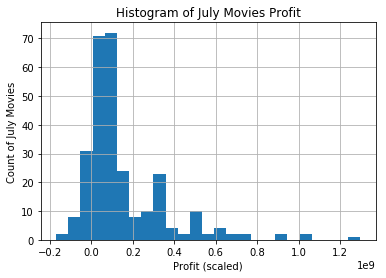

In [50]:
df[df["month"] == 7].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of July Movies')
plt.title('Histogram of July Movies Profit')
f_July = plt.gcf()

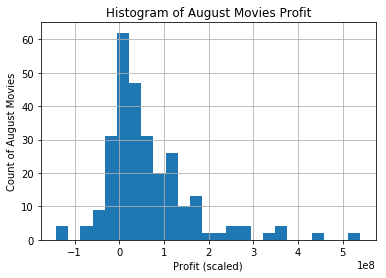

In [51]:
df[df["month"] == 8].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of August Movies')
plt.title('Histogram of August Movies Profit')
f_August = plt.gcf()

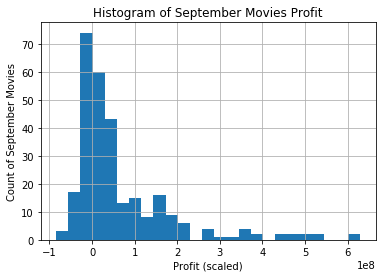

In [52]:
df[df["month"] == 9].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of September Movies')
plt.title('Histogram of September Movies Profit')
f_September = plt.gcf()

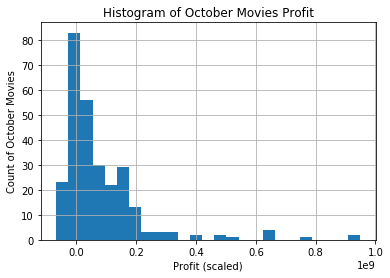

In [53]:
df[df["month"] == 10].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of October Movies')
plt.title('Histogram of October Movies Profit')
f_October = plt.gcf()

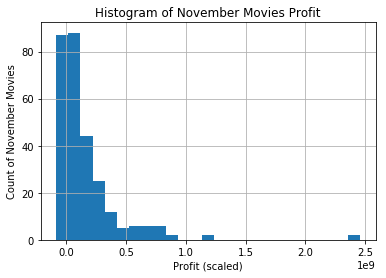

In [54]:
df[df["month"] == 11].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of November Movies')
plt.title('Histogram of November Movies Profit')
f_November = plt.gcf()

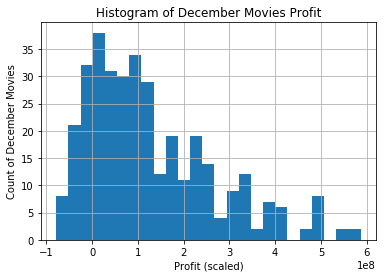

In [55]:
df[df["month"] == 12].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of December Movies')
plt.title('Histogram of December Movies Profit')
f_December = plt.gcf()

# Data Analysis and Results

In [56]:
# Contain each month's profit values in a separate list 
pro_jan = df[df['month'] == 1]['profit'].values
pro_feb = df[df['month'] == 2]['profit'].values
pro_mar = df[df['month'] == 3]['profit'].values
pro_apr = df[df['month'] == 4]['profit'].values
pro_may = df[df['month'] == 5]['profit'].values
pro_jun = df[df['month'] == 6]['profit'].values
pro_jul = df[df['month'] == 7]['profit'].values
pro_aug = df[df['month'] == 8]['profit'].values
pro_sep = df[df['month'] == 9]['profit'].values
pro_oct = df[df['month'] == 10]['profit'].values
pro_nov = df[df['month'] == 11]['profit'].values
pro_dec = df[df['month'] == 12]['profit'].values

In [57]:
# Use the 'normaltest' function to test for normality of the distribution
st_jan, p_jan = stats.normaltest(pro_jan)
st_feb, p_feb = stats.normaltest(pro_feb)
st_mar, p_mar = stats.normaltest(pro_mar)
st_apr, p_apr = stats.normaltest(pro_apr)
st_may, p_may = stats.normaltest(pro_may)
st_jun, p_jun = stats.normaltest(pro_jun)
st_jul, p_jul = stats.normaltest(pro_jul)
st_aug, p_aug = stats.normaltest(pro_aug)
st_sep, p_sep = stats.normaltest(pro_sep)
st_oct, p_oct = stats.normaltest(pro_oct)
st_nov, p_nov = stats.normaltest(pro_nov)
st_dec, p_dec = stats.normaltest(pro_dec)

if p_jun < 0.05:
    is_n_jan = False
else:
    is_n_jan = True
print(is_n_jan)

xs = np.arange(pro_jan.min(), pro_jan.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(pro_jan), np.std(pro_jan))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(pro_jan, normed=True, label='Actual Data');
plt.title('January - profit')
plt.legend();

### First we'll look at the average profit of a movie based on the month of its release date

In [58]:
avg_pro_jan = pro_jan.mean()
avg_pro_feb = pro_feb.mean()
avg_pro_mar = pro_mar.mean()
avg_pro_apr = pro_apr.mean()
avg_pro_may = pro_may.mean()
avg_pro_jun = pro_jun.mean()
avg_pro_jul = pro_jul.mean()
avg_pro_aug = pro_aug.mean()
avg_pro_sep = pro_sep.mean()
avg_pro_oct = pro_oct.mean()
avg_pro_nov = pro_nov.mean()
avg_pro_dec = pro_dec.mean()

#### Average Profit of Movie Based on Month of Release Date

In [182]:
print('January \t $ {:2,.2f}'.format(avg_pro_jan))
print('Febuaray \t $ {:2,.2f}'.format(avg_pro_feb))
print('March \t\t $ {:2,.2f}'.format(avg_pro_mar))
print('April \t\t $ {:2,.2f}'.format(avg_pro_apr))
print('May \t\t $ {:2,.2f}'.format(avg_pro_may))
print('June \t\t $ {:2,.2f}'.format(avg_pro_jun))
print('July \t\t $ {:2,.2f}'.format(avg_pro_jul))
print('August \t\t $ {:2,.2f}'.format(avg_pro_aug))
print('September \t $ {:2,.2f}'.format(avg_pro_sep))
print('October \t $ {:2,.2f}'.format(avg_pro_oct))
print('November \t $ {:2,.2f}'.format(avg_pro_nov))
print('December \t $ {:2,.2f}'.format(avg_pro_dec))

January 	 $ 53,226,190.33
Febuaray 	 $ 70,206,257.25
March 		 $ 99,969,545.22
April 		 $ 99,213,211.90
May 		 $ 216,497,087.71
June 		 $ 242,939,466.86
July 		 $ 150,503,215.67
August 		 $ 63,493,523.49
September 	 $ 65,931,508.92
October 	 $ 79,250,780.87
November 	 $ 160,315,338.81
December 	 $ 128,298,775.72


In [60]:
list = [avg_pro_jan,avg_pro_feb,avg_pro_mar,avg_pro_apr,avg_pro_may,avg_pro_jun,avg_pro_jul,avg_pro_aug,avg_pro_sep,
        avg_pro_oct,avg_pro_nov,avg_pro_dec]
list.sort(key=int)
list

[53226190.32849057,
 63493523.488673836,
 65931508.918286704,
 70206257.248451322,
 79250780.865776166,
 99213211.903472811,
 99969545.21924603,
 128298775.71900569,
 150503215.66507143,
 160315338.81354386,
 216497087.70658118,
 242939466.85618421]

Looking at the sorted list above, we can see that movies released in June, May, November, December, and July are making more profit than the rest of the months. The months we listed are making about a hundred million dollars, whereas the rest of the months are making tens of millions dollars.

### Now, we'll look at the average profit of a movie based on its genre

In [61]:
pro_Drama = df[df['main_genre'] == "Drama"]['profit'].values
pro_Comedy = df[df['main_genre'] == "Comedy"]['profit'].values
pro_Action = df[df['main_genre'] == "Action"]['profit'].values
pro_Adventure = df[df['main_genre'] == "Adventure"]['profit'].values
pro_Crime = df[df['main_genre'] == "Crime"]['profit'].values
pro_Horror = df[df['main_genre'] == "Horror"]['profit'].values
pro_Animation = df[df['main_genre'] == "Animation"]['profit'].values
pro_Fantasy = df[df['main_genre'] == "Fantasy"]['profit'].values
pro_Thriller = df[df['main_genre'] == "Thriller"]['profit'].values
pro_Romance = df[df['main_genre'] == "Romance"]['profit'].values
pro_Science_Fiction = df[df['main_genre'] == "Science Fiction"]['profit'].values
pro_Family = df[df['main_genre'] == "Family"]['profit'].values
pro_Mystery = df[df['main_genre'] == "Mystery"]['profit'].values
pro_Documentary = df[df['main_genre'] == "Documentary"]['profit'].values

In [62]:
avg_pro_Drama = pro_Drama.mean()
avg_pro_Comedy = pro_Comedy.mean()
avg_pro_Action = pro_Action.mean()
avg_pro_Adventure = pro_Adventure.mean()
avg_pro_Crime = pro_Crime.mean()
avg_pro_Animation = pro_Animation.mean()
avg_pro_Horror = pro_Horror.mean()
avg_pro_Thriller = pro_Thriller.mean()
avg_pro_Fantasy = pro_Fantasy.mean()
avg_pro_Romance = pro_Romance.mean()
avg_pro_Science_Fiction = pro_Science_Fiction.mean()
avg_pro_Family = pro_Family.mean()
avg_pro_Mystery = pro_Mystery.mean()
avg_pro_Documentary = pro_Documentary.mean()

#### Average Profit of Movie Based on Genre

In [181]:
print('Drama \t\t $ {:2,.2f}'.format(avg_pro_Drama))
print('Comedy \t\t $ {:2,.2f}'.format(avg_pro_Comedy))
print('Action \t\t $ {:2,.2f}'.format(avg_pro_Action))
print('Adventure \t $ {:2,.2f}'.format(avg_pro_Adventure))
print('Horror \t\t $ {:2,.2f}'.format(avg_pro_Horror))
print('Crime \t\t $ {:2,.2f}'.format(avg_pro_Crime))
print('Animation \t $ {:2,.2f}'.format(avg_pro_Animation))
print('Thriller \t $ {:2,.2f}'.format(avg_pro_Thriller))
print('Fantasy \t $ {:2,.2f}'.format(avg_pro_Fantasy))
print('Romance \t $ {:2,.2f}'.format(avg_pro_Romance))
print('Science Fiction  $ {:2,.2f}'.format(avg_pro_Science_Fiction))
print('Family \t\t $ {:2,.2f}'.format(avg_pro_Family))
print('Mystery \t $ {:2,.2f}'.format(avg_pro_Mystery))
print('Documentary \t $ {:2,.2f}'.format(avg_pro_Documentary))

Drama 		 $ 77,430,809.13
Comedy 		 $ 87,639,961.28
Action 		 $ 131,022,965.90
Adventure 	 $ 224,685,720.49
Horror 		 $ 79,385,661.16
Crime 		 $ 74,390,269.56
Animation 	 $ 276,752,089.30
Thriller 	 $ 112,609,070.44
Fantasy 	 $ 184,877,015.78
Romance 	 $ 124,004,704.67
Science Fiction  $ 224,334,316.81
Family 		 $ 317,038,190.16
Mystery 	 $ 49,438,678.08
Documentary 	 $ 17,800,210.77


### Now we'll look at a movies' vote averages based on the month.

In [142]:
vote_jan = df[df["month"] == 1]["vote_average"].values
vote_feb = df[df["month"] == 2]["vote_average"].values
vote_mar = df[df["month"] == 3]["vote_average"].values
vote_apr = df[df["month"] == 4]["vote_average"].values
vote_may = df[df["month"] == 5]["vote_average"].values
vote_jun = df[df["month"] == 6]["vote_average"].values
vote_jul = df[df["month"] == 7]["vote_average"].values
vote_aug = df[df["month"] == 8]["vote_average"].values
vote_sep = df[df["month"] == 9]["vote_average"].values
vote_oct = df[df["month"] == 10]["vote_average"].values
vote_nov = df[df["month"] == 11]["vote_average"].values
vote_dec = df[df["month"] == 12]["vote_average"].values


In [143]:
avg_vote_jan = vote_jan.mean()
avg_vote_feb = vote_feb.mean()
avg_vote_mar = vote_mar.mean()
avg_vote_apr = vote_apr.mean()
avg_vote_may = vote_may.mean()
avg_vote_jun = vote_jun.mean()
avg_vote_jul = vote_jul.mean()
avg_vote_aug = vote_aug.mean()
avg_vote_sep = vote_sep.mean()
avg_vote_oct = vote_oct.mean()
avg_vote_nov = vote_nov.mean()
avg_vote_dec = vote_dec.mean()

#### Average Vote of Movies by Month

In [180]:
print("January \t", avg_vote_jan)
print("February \t", avg_vote_feb)
print("March \t\t", avg_vote_mar)
print("April \t\t", avg_vote_apr)
print("May \t\t", avg_vote_may)
print("June \t\t", avg_vote_jun)
print("July \t\t", avg_vote_jul)
print("August \t\t", avg_vote_aug)
print("September \t", avg_vote_sep)
print("October \t", avg_vote_oct)
print("November \t", avg_vote_nov)
print("December \t", avg_vote_dec)

January 	 5.85031446541
February 	 6.07743362832
March 		 6.06904761905
April 		 6.12594142259
May 		 6.28974358974
June 		 6.18848684211
July 		 6.16178571429
August 		 6.01863799283
September 	 6.43391608392
October 	 6.28700361011
November 	 6.33543859649
December 	 6.44176136364


### Now we'll take a look at the ratios by genre for each month

In [167]:
# Use the method below to get the ratio of each genres in a month. 
def ratio_genre(df):
    values = df.value_counts().keys().tolist()
    counts = df.value_counts().tolist()
    total = len(df)
    j = 0
    for i in counts:
        ratio = i/total
        if len(values[j]) > 7:
            print(values[j] + "\t {:2.3f}".format(ratio))
        else: 
            print(values[j] + "\t\t {:2.3f}".format(ratio))
        j = j+1

#### Ratios by Genre for January 

In [168]:
toCkeck1 = df[df["month"]==1]['main_genre']
ratio_genre(toCkeck1)

Action		 0.270
Comedy		 0.233
Drama		 0.107
Horror		 0.094
Thriller	 0.069
Crime		 0.063
Adventure	 0.063
Science Fiction	 0.025
Fantasy		 0.025
Mystery		 0.013
Romance		 0.013
Music		 0.013
War		 0.013


#### Ratios by Genre for February 

In [169]:
toCkeck2 = df[df["month"]==2]['main_genre']
ratio_genre(toCkeck2)

Comedy		 0.283
Drama		 0.195
Action		 0.173
Adventure	 0.080
Crime		 0.062
Thriller	 0.044
Romance		 0.040
Animation	 0.022
Fantasy		 0.022
Music		 0.022
Science Fiction	 0.018
Horror		 0.018
Mystery		 0.013
Family		 0.009


#### Ratios by Genre for March 

In [170]:
toCkeck3 = df[df["month"]==3]['main_genre']
ratio_genre(toCkeck3)

Comedy		 0.198
Action		 0.194
Drama		 0.171
Adventure	 0.079
Crime		 0.075
Animation	 0.060
Science Fiction	 0.044
Horror		 0.044
Romance		 0.036
Thriller	 0.024
Fantasy		 0.024
War		 0.020
Family		 0.016
Mystery		 0.008
Music		 0.008


#### Ratios by Genre for April 

In [171]:
toCkeck4 = df[df["month"]==4]['main_genre']
ratio_genre(toCkeck4)

Comedy		 0.305
Action		 0.255
Drama		 0.134
Thriller	 0.063
Crime		 0.063
Horror		 0.050
Adventure	 0.050
Science Fiction	 0.017
Animation	 0.017
Family		 0.017
Mystery		 0.008
Western		 0.008
Documentary	 0.004
Fantasy		 0.004
Music		 0.004


#### Ratios by Genre for May 

In [172]:
toCkeck5 = df[df["month"]==5]['main_genre']
ratio_genre(toCkeck5)

Action		 0.218
Adventure	 0.167
Comedy		 0.162
Drama		 0.107
Fantasy		 0.094
Science Fiction	 0.064
Thriller	 0.056
Horror		 0.043
Family		 0.021
Romance		 0.017
Crime		 0.013
Documentary	 0.009
Animation	 0.009
Western		 0.009
War		 0.009
Music		 0.004


#### Ratios by Genre for June 

In [173]:
toCkeck6 = df[df["month"]==6]['main_genre']
ratio_genre(toCkeck6)

Comedy		 0.243
Action		 0.240
Animation	 0.112
Adventure	 0.112
Drama		 0.099
Romance		 0.033
Science Fiction	 0.026
Crime		 0.026
Horror		 0.023
Family		 0.023
Fantasy		 0.023
Thriller	 0.020
Documentary	 0.007
Mystery		 0.007
Music		 0.007


#### Ratios by Genre for July 

In [174]:
toCkeck7 = df[df["month"]==7]['main_genre']
ratio_genre(toCkeck7)

Action		 0.264
Comedy		 0.246
Adventure	 0.125
Drama		 0.104
Fantasy		 0.086
Animation	 0.036
Horror		 0.036
Crime		 0.025
Family		 0.018
Romance		 0.018
Thriller	 0.014
Mystery		 0.014
History		 0.007
Music		 0.007


#### Ratios by Genre for August 

In [175]:
toCkeck8 = df[df["month"]==8]['main_genre']
ratio_genre(toCkeck8)

Action		 0.240
Comedy		 0.208
Drama		 0.201
Horror		 0.097
Adventure	 0.072
Crime		 0.039
Science Fiction	 0.029
Thriller	 0.022
Romance		 0.022
Fantasy		 0.018
Music		 0.014
Animation	 0.011
Documentary	 0.007
Mystery		 0.007
Family		 0.007
History		 0.007


#### Ratios by Genre for September 

In [176]:
toCkeck9 = df[df["month"]==9]['main_genre']
ratio_genre(toCkeck9)

Drama		 0.346
Comedy		 0.171
Action		 0.140
Thriller	 0.070
Crime		 0.066
Adventure	 0.066
Animation	 0.035
Romance		 0.031
Horror		 0.028
Mystery		 0.021
Documentary	 0.010
Science Fiction	 0.007
War		 0.007


#### Ratios by Genre for October 

In [177]:
toCkeck10 = df[df["month"]==10]['main_genre']
ratio_genre(toCkeck10)

Comedy		 0.227
Drama		 0.195
Horror		 0.166
Action		 0.130
Adventure	 0.065
Fantasy		 0.036
Mystery		 0.029
Thriller	 0.025
Family		 0.025
Romance		 0.025
Crime		 0.022
Documentary	 0.014
War		 0.014
Animation	 0.011
Science Fiction	 0.007
Music		 0.007


#### Ratios by Genre for November 

In [178]:
toCkeck11 = df[df["month"]==11]['main_genre']
ratio_genre(toCkeck11)

Drama		 0.253
Comedy		 0.186
Action		 0.140
Adventure	 0.116
Animation	 0.067
Science Fiction	 0.042
Horror		 0.039
Fantasy		 0.039
Thriller	 0.032
Family		 0.032
Crime		 0.032
Romance		 0.018
Mystery		 0.007


#### Ratios by Genre for December 

In [179]:
toCkeck12 = df[df["month"]==12]['main_genre']
ratio_genre(toCkeck12)

Drama		 0.355
Comedy		 0.267
Action		 0.105
Adventure	 0.074
Thriller	 0.040
Romance		 0.026
Science Fiction	 0.026
Fantasy		 0.026
Crime		 0.023
Animation	 0.017
Horror		 0.017
War		 0.011
Western		 0.006
Family		 0.003
History		 0.003
Music		 0.003


## Linear Models
In the next following cells, we will make some linear models, using Ordinary Least Squares (OLS). 

In [80]:
# Creates a linear model to predict profit from month (using df as data)
outcome_1, predictors_1 = patsy.dmatrices('profit ~ month', df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [81]:
# Print out the summary results of the model fitting
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.896
Date:                Thu, 22 Mar 2018   Prob (F-statistic):              0.169
Time:                        14:27:46   Log-Likelihood:                -65164.
No. Observations:                3173   AIC:                         1.303e+05
Df Residuals:                    3171   BIC:                         1.303e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.125e+08   8.22e+06     13.685      0.0

In [82]:
# Creates a linear model to predict profit from both month and genre (using df as data)
outcome_2, predictors_2 = patsy.dmatrices('profit ~ month + main_genre', df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

In [83]:
# Print out the results 
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     18.15
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.91e-55
Time:                        14:27:46   Log-Likelihood:                -65008.
No. Observations:                3173   AIC:                         1.301e+05
Df Residuals:                    3154   BIC:                         1.302e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [84]:
# Creates a linear model to predict profit from both month, main production, and genre (using df as data)
outcome_3, predictors_3 = patsy.dmatrices('profit ~ month + main_genre + main_production_company', df)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()

In [85]:
# Print out the results 
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     11.05
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           9.55e-60
Time:                        14:27:46   Log-Likelihood:                -64970.
No. Observations:                3173   AIC:                         1.300e+05
Df Residuals:                    3135   BIC:                         1.302e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [86]:
# Creates a linear model to predict profit from vote_average (using df as data)
outcome_4, predictors_4 = patsy.dmatrices('profit ~ vote_average', df)
mod_4 = sm.OLS(outcome_4, predictors_4)
res_4 = mod_4.fit()

In [87]:
# Print out the results 
print(res_4.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     337.6
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           9.94e-72
Time:                        14:27:46   Log-Likelihood:                -65004.
No. Observations:                3173   AIC:                         1.300e+05
Df Residuals:                    3171   BIC:                         1.300e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.591e+08   2.64e+07    -13.582   

In [88]:
# Creates a linear model to predict profit from both vote_average and genre (using df as data)
outcome_5, predictors_5 = patsy.dmatrices('profit ~ vote_average + main_genre', df)
mod_5 = sm.OLS(outcome_5, predictors_5)
res_5 = mod_5.fit()

In [89]:
# Print out the results 
print(res_5.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     44.61
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          1.31e-140
Time:                        14:27:46   Log-Likelihood:                -64805.
No. Observations:                3173   AIC:                         1.296e+05
Df Residuals:                    3154   BIC:                         1.298e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [90]:
# Creates a linear model to predict profit from both month and vote_average (using df as data)
outcome_6, predictors_6 = patsy.dmatrices('profit ~ vote_average + month', df)
mod_6 = sm.OLS(outcome_6, predictors_6)
res_6 = mod_6.fit()

In [91]:
# Print out the results 
print(res_6.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     169.9
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           7.85e-71
Time:                        14:27:46   Log-Likelihood:                -65003.
No. Observations:                3173   AIC:                         1.300e+05
Df Residuals:                    3170   BIC:                         1.300e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.548e+08   2.66e+07    -13.339   

In [92]:
# Creates a linear model to predict profit from adjusted_budget (using df as data)
outcome_7, predictors_7 = patsy.dmatrices('profit ~ adjusted_budget', df)
mod_7 = sm.OLS(outcome_7, predictors_7)
res_7 = mod_7.fit()

In [93]:
# Print out the results 
print(res_7.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     935.4
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          2.95e-180
Time:                        14:27:46   Log-Likelihood:                -64755.
No. Observations:                3173   AIC:                         1.295e+05
Df Residuals:                    3171   BIC:                         1.295e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        7.635e+06    4.9e+06     

In [94]:
# Creates a linear model to predict profit from both adjusted_budget and vote_average (using df as data)
outcome_8, predictors_8 = patsy.dmatrices('profit ~ adjusted_budget + vote_average', df)
mod_8 = sm.OLS(outcome_8, predictors_8)
res_8 = mod_8.fit()

In [95]:
# Print out the results 
print(res_8.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     713.9
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          1.05e-256
Time:                        14:27:46   Log-Likelihood:                -64575.
No. Observations:                3173   AIC:                         1.292e+05
Df Residuals:                    3170   BIC:                         1.292e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -4.364e+08   2.32e+07    -

In [96]:
# Creates a linear model to predict profit from both month, adjusted_budget, and vote_average (using df as data)
outcome_9, predictors_9 = patsy.dmatrices('profit ~ adjusted_budget + vote_average + month', df)
mod_9 = sm.OLS(outcome_9, predictors_9)
res_9 = mod_9.fit()

In [97]:
# Print out the results 
print(res_9.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     478.3
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          2.47e-256
Time:                        14:27:46   Log-Likelihood:                -64572.
No. Observations:                3173   AIC:                         1.292e+05
Df Residuals:                    3169   BIC:                         1.292e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -4.307e+08   2.34e+07    -

# Privacy/Ethics Considerations
We do have permission to use this data, for this purpose. These are open, public datasets released on Kaggle. There are no privacy concerns regarding our datasets that we need to deal with and there are no terms of use that we need to comply with. However, there are biases in our dataset. Dropping the production companies that did not produce the specified amount of films, made our data consist of well-known companies. This means that our data may have been biased towards main-stream production companies. Indie films were probably lost from our finalized data because indie films tend to be made by more indie productions, which probably do not produce as many as the more main stream production companies. These lists contain more American movies, so the genres are more geared toward Hollywood. Also, due to inflation, the value of money varied by year. To address this, we used an inflation rate package to find the adjusted value for ‘budget’ and ‘revenue’ (to the year 2016). We also trimmed the list to movies made after 1989. There did not seem to be any other issues related to our topic area, data, and/or analyses that are problematic in terms of data privacy and equitable impact.

# Conclusions and Discussions

In [ ]:
#  We have evidence supporting our research question:
#    Are there specific months for movie release dates that generate more revenue 
#   in the box office? Is there a correlation between movie budgets and their success in the box office?

ans = True



summarizing the results:
big budget, mid-summer movie releases generate greater revenue

Conclusions ：We started with checking the different production companies, including how many films were produced from each company. Any production company that produces more than 50 films will be kept in our data. By plot the data, using scatter matrix and bar chart, we want to visualize the number of movies in each genre and movies' return rates. We hope to find the correlation between genera and profit, month and profit. By looking at the sorted list, we see that movies released in June, May, November, December, and July are making more profits compared to that of the rest of the month. We then did data analysis to find the average profit of movies in different genres. Family movie is that genre that makes the most profit 317038190.16 dollar. Our data contain no identifiable information about people included in the dataset. We has followed the set of guidelines and requirements regarding the treatment of human subjects, and the collection, storage, use, and dissemination of data for our data collected and used for research purposes. 

Discussions：This project will contribute to the movie industry. They can make prediction that movies released in certain month and in certain genre in the United States will sell more tickets. One problem of the project is that we are only analysiize the data from the United State box office. Users cannot make prediction of international seel using this project. Also, consumer tastes and demands change, movie producers should not only focus on the profit. We should value real arts as well.